In [25]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from IPython import display

In [26]:
DATASET_PATH = 'data_cuted'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['batden' 'batdieuhoa' 'batquat' 'dongcua' 'giamtocdoquat' 'mocua'
 'tangtocdoquat' 'tatden' 'tatdieuhoa' 'tatquat']


In [27]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

def remove_sil(path_in, path_out, format="wav"):
    sound = AudioSegment.from_file(path_in, format=format)
    non_sil_times = detect_nonsilent(sound, min_silence_len=50, silence_thresh=sound.dBFS * 1.25)
    if len(non_sil_times) > 0:
        non_sil_times_concat = [non_sil_times[0]]
        if len(non_sil_times) > 1:
            for t in non_sil_times[1:]:
                if t[0] - non_sil_times_concat[-1][-1] < 50:
                    non_sil_times_concat[-1][-1] = t[1]
                else:
                    non_sil_times_concat.append(t)
        non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 80]
        sound[non_sil_times[0][0]: non_sil_times[-1][1]].export(path_out, format='wav')

In [28]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [29]:
def get_spectrogram(waveform):
  input_len = 32000
  waveform = waveform[:input_len]
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  # Resize the spectrogram to a fixed size (e.g., 224x224).
  spectrogram = tf.image.resize(spectrogram, size=(256, 256))
  return spectrogram

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [31]:
model = tf.keras.models.load_model('CNNs.h5')

In [47]:
import pyaudio
import wave

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 512
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "new_audio.wav"

p = pyaudio.PyAudio()

# Tìm kiếm thiết bị âm thanh
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if 'Microphone' in dev['name']:
        device_name = dev['name']
        break
print('Bắt đầu ghi âm...')
# Khởi tạo stream
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, input_device_index=i, frames_per_buffer=CHUNK)

# Ghi âm
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print('Đã ghi âm xong!')

# Dừng stream
stream.stop_stream()
stream.close()
p.terminate()

# Lưu file âm thanh
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

# remove_silence(WAVE_OUTPUT_FILENAME)
remove_sil("new_audio.wav","audio.wav")

# Đọc file âm thanh đã cắt
new_audio_binary = tf.io.read_file("audio.wav")
new_waveform = decode_audio(new_audio_binary)
new_spectrogram = get_spectrogram(new_waveform)
new_spectrogram = tf.expand_dims(new_spectrogram, axis=0)
predictions = model.predict(new_spectrogram)

# Chuyển đổi các xác suất thành nhãn
predicted_label_id = np.argmax(predictions[0])
predicted_label = commands[predicted_label_id]
positive_predictions = predictions[predictions > 0]
print(np.sum(positive_predictions))
print(np.sum(predictions))
print(np.max(predictions[0]))
print(np.max(predictions[0])-np.min(predictions[0]))
if np.max(predictions[0])<20:
    print("Sai rồi em ơi")

print('Predicted label:', predicted_label)

Bắt đầu ghi âm...
Đã ghi âm xong!
1/1 [==============================] - 0s 20ms/step
49.1715
-32.63186
20.91828
41.76674
Predicted label: batquat


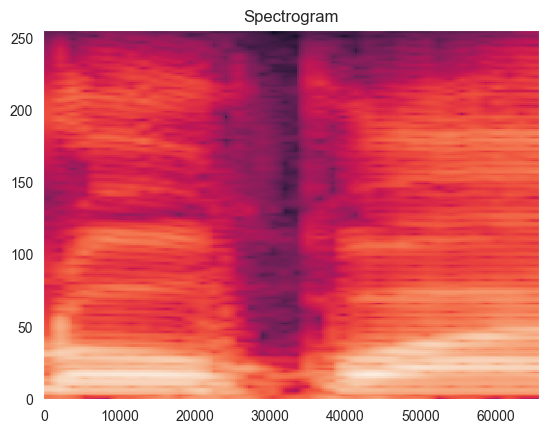

In [44]:
fig, ax = plt.subplots()
plot_spectrogram(new_spectrogram.numpy().reshape(new_spectrogram.shape[1], new_spectrogram.shape[2]), ax)
ax.set(title='Spectrogram')
plt.show()